# Credit Card Fraud Detection

## Dependency

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import time
import collections

pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)
plt.style.use('default')

## Parameter

In [95]:
CSV_01 = '../data/creditcard.csv'
RANDOM_STATE = 0
THRESHOLD_IQR = 1.5
K_CV = 5  # K-fold cross validation
TEST_SIZE = 0.2
PARAMETERS_LOG_REG = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear']
}

## Data

In [3]:
df = pd.read_csv(CSV_01)

In [4]:
print(df.shape)

(284807, 31)


In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [8]:
num_class_0 = df['Class'].value_counts()[0]
num_class_1 = df['Class'].value_counts()[1]

print(f'Fraud: {num_class_1 / len(df):.2%}, count: {num_class_1:,}')
print(f'Non-fraud: {num_class_0 / len(df):.2%}, count: {num_class_0:,}')

Fraud: 0.17%, count: 492
Non-fraud: 99.83%, count: 284,315


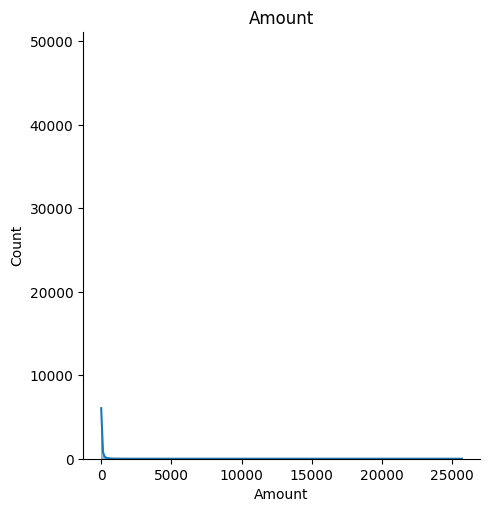

In [9]:
sns.displot(df['Amount'], kde=True)
plt.title('Amount')
plt.show()

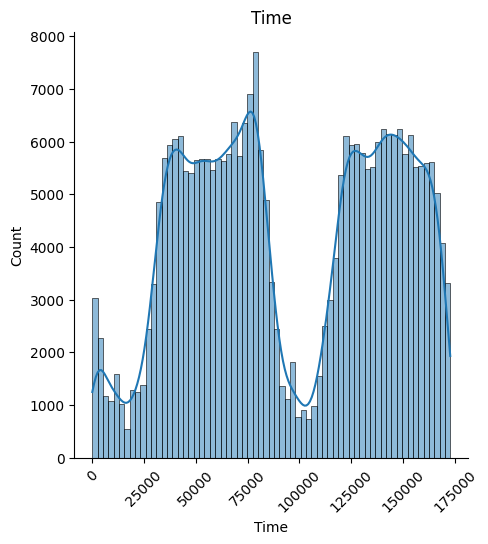

In [10]:
sns.displot(df['Time'], kde=True)
plt.title('Time')
plt.xticks(rotation=45)
plt.show()

## Preprocess data

In [11]:
# std_scaler = StandardScaler()
# RobustScaler is less prone to outliers
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df[['Amount']])
df['scaled_time'] = rob_scaler.fit_transform(df[['Time']])
df.drop(['Amount', 'Time'], axis=1, inplace=True)

In [12]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


## Split data

## Make balanced data

In [61]:
df = shuffle(df, random_state=RANDOM_STATE)

df_fraud = df.loc[df['Class'] == 1]
df_non_fraud = df.loc[df['Class'] == 0][:len(df_fraud)]

df_balanced = pd.concat([df_fraud, df_non_fraud])
df_balanced = shuffle(df_balanced, random_state=RANDOM_STATE)

In [62]:
print(df_balanced.shape)

(984, 31)


In [15]:
df_balanced.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
74794,-6.003422,-3.930731,-0.007045,1.714669,3.414667,-2.329583,-1.901512,-2.746111,0.887673,-0.049233,-0.153131,-0.814310,-1.894796,-0.831483,1.387289,1.188907,0.536817,-0.051403,-1.231386,-4.128186,1.101671,-0.992494,-0.698259,0.139898,-0.205151,-0.472412,1.775378,-0.104285,1,4.051003,-0.339901
264755,0.285994,-3.500172,0.120214,2.870073,-2.219233,1.735747,-0.809120,0.517737,1.304203,0.572238,-0.843588,-0.095421,-1.652901,-0.781826,-2.591612,1.292730,-0.278208,0.348355,-0.443393,1.347581,0.495849,-0.060820,-0.444735,-0.340144,-1.153573,2.258126,-0.248557,0.067937,0,10.995319,0.903324
223572,-2.729482,3.312495,-4.242710,5.036985,-0.376561,-1.532462,-3.449159,1.856839,-3.623334,-5.653638,3.942316,-5.883724,-1.347814,-9.266120,-2.459556,-2.205644,-5.709087,-1.113937,-1.556530,0.164288,0.727415,-0.301432,-0.502433,-0.462309,0.510683,0.046665,0.514646,0.140999,1,-0.293440,0.690116
119634,0.364647,-1.868803,0.195291,0.395567,-1.140283,0.370634,-0.015770,-0.027628,1.157162,-0.683766,-1.618061,0.478853,0.640767,-0.588908,-0.213943,0.216853,-0.230232,-0.263339,0.690443,0.948612,-0.007493,-0.815611,-0.467571,-0.500501,0.109927,0.952522,-0.122180,0.087820,0,6.451338,-0.107685
82678,1.277862,-1.218097,0.436517,-1.443919,-0.943716,0.816429,-1.234908,0.338397,-1.845883,1.249644,0.727192,-0.541243,0.093744,-0.108782,1.664313,-1.748267,1.848211,-2.056222,-1.922357,-0.460539,-0.066430,0.302245,0.191320,-0.666031,0.013571,-0.098652,0.096963,0.011778,0,0.111786,-0.295950


In [16]:
df_balanced.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
186089,-0.167691,-3.980152,-2.142284,0.743356,-0.492609,2.177803,0.642303,0.334988,0.805490,-0.518958,0.721973,1.014612,-0.249074,0.422474,0.171039,-0.216744,0.117763,-1.166191,-0.586742,1.902274,0.291048,-1.403348,-0.430216,-0.923080,-1.168787,0.114165,-0.207068,0.117209,0,14.694613,0.496470
83297,-8.257111,-4.814461,-5.365307,1.204230,-3.347420,-1.331601,-1.967893,1.295438,-1.674415,-3.426052,0.144563,-4.283529,-0.240895,-3.657490,0.923105,0.844221,-3.948312,-1.807516,0.105879,-1.233987,0.436390,-0.077553,-3.091624,-0.390201,-0.288689,-0.340004,0.039819,-1.007900,1,4.152868,-0.292708
283058,0.033018,0.858204,0.291487,-0.592185,0.439971,-1.037469,1.006416,-0.185681,-0.055867,-0.422385,-0.865551,0.190561,0.069113,0.105663,-0.362691,-0.154503,-0.355888,-0.844524,-0.156554,-0.038014,-0.253129,-0.542716,0.078816,-0.018576,-0.501647,0.143164,0.250287,0.097094,0,-0.244673,1.018034
61838,1.338163,-0.516868,-0.420871,-0.741825,-0.278045,-0.068333,-0.513050,0.001108,-0.839951,0.267470,0.542857,-0.196515,0.358449,-1.259065,-0.569495,1.643516,0.623833,-0.390529,1.380575,0.244623,-0.075401,-0.319569,-0.211086,-0.891701,0.592074,-0.252162,0.009146,0.024638,0,0.511842,-0.407453
121645,1.146568,0.187897,0.604728,0.597011,-0.231455,-0.228417,-0.055365,0.026434,-0.052033,-0.168696,0.605344,0.884799,0.654339,0.229815,1.466425,-0.404312,0.234709,-1.609060,-0.970648,-0.136382,-0.173576,-0.417258,0.230682,0.102195,0.040089,0.131822,0.007080,0.016822,0,-0.257249,-0.099014


In [17]:
df_balanced['Class'].value_counts() / len(df_balanced)

1    0.5
0    0.5
Name: Class, dtype: float64

## Correlation matrix

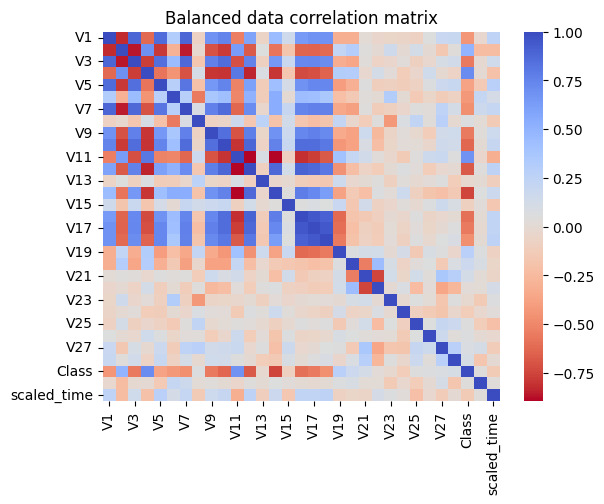

In [18]:
corr = df_balanced.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size': 20})
plt.title('Balanced data correlation matrix')
plt.show()

In [35]:
print('Features positively correlated to response')
corr[['Class']] \
    .loc[(corr['Class'] > 0.5) & (corr.index != 'Class')] \
    .sort_values(by='Class', ascending=False)

Features positively correlated to response


,Class
V4,0.714506
V11,0.687442


In [36]:
print('Features negatively correlated to response')
corr[['Class']] \
    .loc[(corr['Class'] < -0.5) & (corr.index != 'Class')] \
    .sort_values(by='Class', ascending=True)

Features negatively correlated to response


,Class
V14,-0.749640
V12,-0.679064
V10,-0.628541
V16,-0.594907
V3,-0.561426
V9,-0.561400
V17,-0.558734


## Box plot

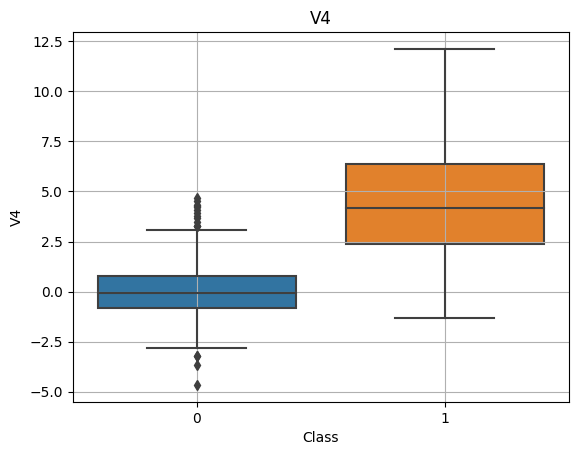

In [42]:
c = 'V4'
sns.boxplot(x='Class', y=c, data=df_balanced)
plt.title(c)
plt.grid()
plt.show()

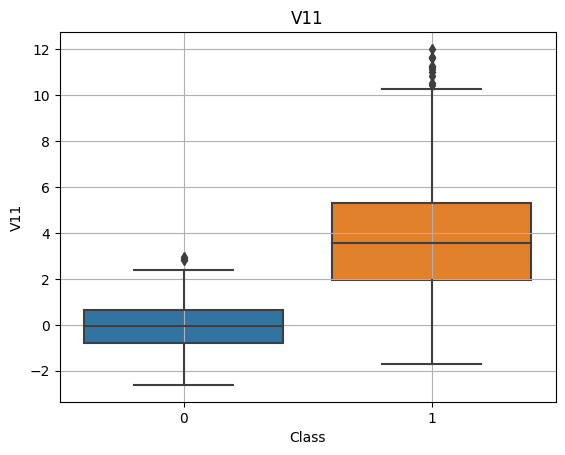

In [43]:
c = 'V11'
sns.boxplot(x='Class', y=c, data=df_balanced)
plt.title(c)
plt.grid()
plt.show()

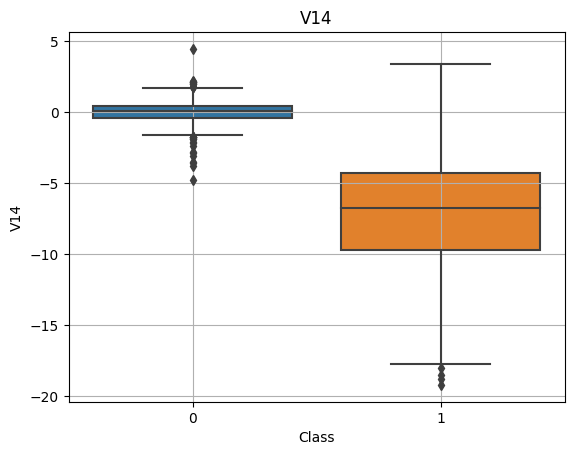

In [44]:
c = 'V14'
sns.boxplot(x='Class', y=c, data=df_balanced)
plt.title(c)
plt.grid()
plt.show()

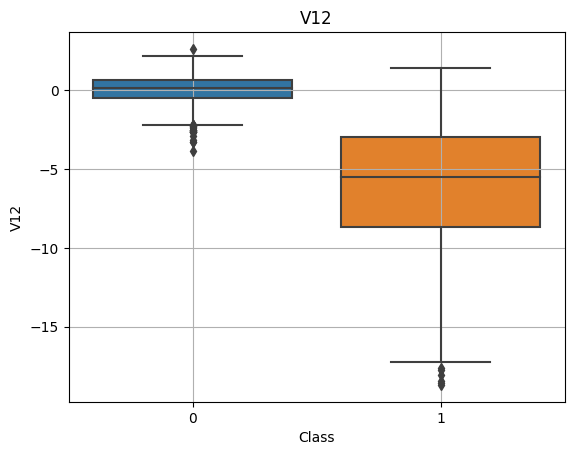

In [45]:
c = 'V12'
sns.boxplot(x='Class', y=c, data=df_balanced)
plt.title(c)
plt.grid()
plt.show()

## Remove outliers

In [63]:
print(df_balanced.shape)

(984, 31)


In [64]:
v14_fraud = df_balanced['V14'].loc[df_balanced['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
v14_iqr = q75 - q25
v14_cutoff = v14_iqr * THRESHOLD_IQR
v14_lower, v14_upper = q25 - v14_cutoff, q75 + v14_cutoff
v14_outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]

print(f'V14, q25: {q25:.1f}, q75: {q75:.1f}, IQR: {v14_iqr:.1f}')
print(f'V14 lower cutoff: {v14_lower:.1f}, upper cutoff: {v14_upper:.1f}')
print(f'Number of outliers by V14 cutoff: {len(v14_outliers)}')

df_balanced = df_balanced.loc[(df_balanced['V14'] >= v14_lower) & (df_balanced['V14'] <= v14_upper)]
print(df_balanced.shape)

V14, q25: -9.7, q75: -4.3, IQR: 5.4
V14 lower cutoff: -17.8, upper cutoff: 3.8
Number of outliers by V14 cutoff: 4
(980, 31)


In [65]:
v12_fraud = df_balanced['V12'].loc[df_balanced['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25
v12_cutoff = v12_iqr * THRESHOLD_IQR
v12_lower, v12_upper = q25 - v12_cutoff, q75 + v12_cutoff
v12_outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]

print(f'V12, q25: {q25:.1f}, q75: {q75:.1f}, IQR: {v12_iqr:.1f}')
print(f'V12 lower cutoff: {v12_lower:.1f}, upper cutoff: {v12_upper:.1f}')
print(f'Number of outliers by V12 cutoff: {len(v12_outliers)}')

df_balanced = df_balanced.loc[(df_balanced['V12'] >= v12_lower) & (df_balanced['V12'] <= v12_upper)]
print(df_balanced.shape)

V12, q25: -8.7, q75: -2.9, IQR: 5.8
V12 lower cutoff: -17.3, upper cutoff: 5.8
Number of outliers by V12 cutoff: 4
(976, 31)


In [66]:
v10_fraud = df_balanced['V10'].loc[df_balanced['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25
v10_cutoff = v10_iqr * THRESHOLD_IQR
v10_lower, v10_upper = q25 - v10_cutoff, q75 + v10_cutoff
v10_outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]

print(f'V10, q25: {q25:.1f}, q75: {q75:.1f}, IQR: {v10_iqr:.1f}')
print(f'V10 lower cutoff: {v10_lower:.1f}, upper cutoff: {v10_upper:.1f}')
print(f'Number of outliers by V10 cutoff: {len(v10_outliers)}')

df_balanced = df_balanced.loc[(df_balanced['V10'] >= v10_lower) & (df_balanced['V10'] <= v10_upper)]
print(df_balanced.shape)

V10, q25: -7.5, q75: -2.5, IQR: 5.0
V10 lower cutoff: -14.9, upper cutoff: 4.9
Number of outliers by V10 cutoff: 27
(948, 31)


## Clustering to reduce dimention into 2D

In [77]:
df_tmp = df_balanced.copy()
X = df_tmp.drop('Class', axis=1)
y = df_tmp['Class']

# t-SNE
X_reduced_tsne = TSNE(n_components=2, random_state=RANDOM_STATE).fit_transform(X.values)

# PCA
X_reduced_pca = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(X.values)

# TruncatedSVD
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=RANDOM_STATE).fit_transform(X.values)

C:\Users\ykitayama\PycharmProjects\machine-learning\env-machine-learning\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\ykitayama\PycharmProjects\machine-learning\env-machine-learning\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


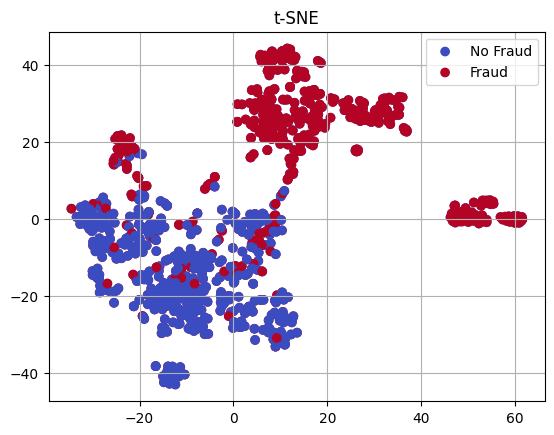

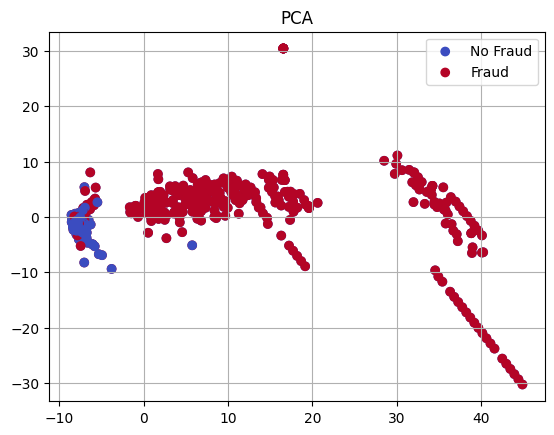

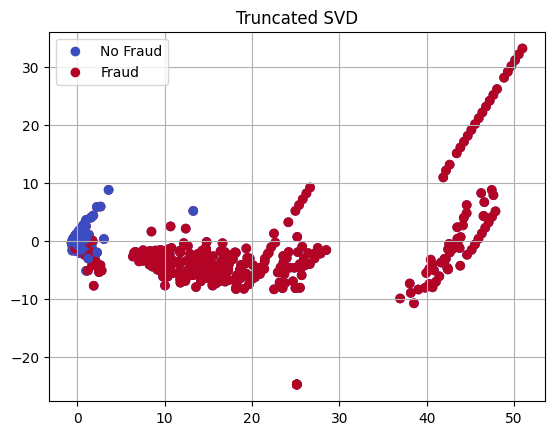

In [83]:
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y==0), cmap='coolwarm', label='No Fraud')
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y==1), cmap='coolwarm', label='Fraud')
plt.title('t-SNE')
plt.legend()
plt.grid()
plt.show()

plt.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=(y==0), cmap='coolwarm', label='No Fraud')
plt.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=(y==1), cmap='coolwarm', label='Fraud')
plt.title('PCA')
plt.legend()
plt.grid()
plt.show()

plt.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=(y==0), cmap='coolwarm', label='No Fraud')
plt.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=(y==1), cmap='coolwarm', label='Fraud')
plt.title('Truncated SVD')
plt.legend()
plt.grid()
plt.show()

## Develop model

In [90]:
X = df_balanced.drop('Class', axis=1)
y = df_balanced['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

model = LogisticRegression()

training_score = cross_val_score(model, X_train.values, y_train.values, cv=K_CV)

print(f'K-fold cross validation score of logistic regression: {training_score.mean():.1%}')
print(f'{training_score}')

K-fold cross validation score of logistic regression: 92.5%
[0.90131579 0.96710526 0.90131579 0.9205298  0.93377483]


## Hyperparameter tuning

In [96]:
model = LogisticRegression()

gs_cv = GridSearchCV(model, PARAMETERS_LOG_REG, cv=K_CV)
gs_cv.fit(X_train.values, y_train.values)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [103]:
print(gs_cv.best_params_)

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [107]:
model = LogisticRegression(penalty='l2', C=0.1, solver='liblinear')
training_score = cross_val_score(model, X_train.values, y_train.values, cv=K_CV)

print(f'K-fold cross validation score of logistic regression after hyperparameter tuning: {training_score.mean():.1%}')
print(f'{training_score}')

K-fold cross validation score of logistic regression after hyperparameter tuning: 92.9%
[0.93421053 0.96710526 0.90131579 0.9205298  0.9205298 ]


## Predict test data
- I think the way to make a test data is wrong, because in reality data is not balanced

In [121]:
# model.fit(X_train.values, y_train.values)

# y_pred = model.predict(X_test.values)
# y_prob = model.predict_proba(X_test.values)[:, 1]

# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_prob)

# print(f'Accuracy: {accuracy:.1%}')
# print(f'F1: {f1:.1%}')
# print(f'Precision: {precision:.1%}')
# print(f'Recall: {recall:.1%}')
# print(f'ROC AUC: {roc_auc:.1%}')

## Reference
- [Credit Fraud || Dealing with Imbalanced Datasets](https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets)